# <font color = "red"> Utilizando a Arquitetura LTSM para prever o próximo valor da Taxa Selic

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf # modelo de deep learn
from sklearn.preprocessing import MinMaxScaler # normalizar os dados
from sklearn.metrics import mean_squared_error # calcular o erro
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Carregamento dos dados
dados = pd.read_csv("C:/Projetos Pessoais/DataScience/Previsao_Juros_BACEN_IA/data/dados_scraping")

In [10]:
dados

,Data,Taxa_Selic
0,06/11/2024,"11,25"
1,18/09/2024,"10,75"
2,31/07/2024,"10,50"
3,19/06/2024,"10,50"
4,08/05/2024,"10,50"
...,...,...
269,23/10/1996,"1,78"
270,23/09/1996,"1,82"
271,21/08/1996,"1,88"
272,30/07/1996,"1,90"


Invertendo a ordem do DataFrame, para facilitar o treinamento do modelo

In [14]:
dados_selic = dados.iloc[::-1].reset_index(drop=True)

# Exibindo o DataFrame invertido
dados_selic

,Data,Taxa_Selic
0,26/06/1996,"1,90"
1,30/07/1996,"1,90"
2,21/08/1996,"1,88"
3,23/09/1996,"1,82"
4,23/10/1996,"1,78"
...,...,...
269,08/05/2024,"10,50"
270,19/06/2024,"10,50"
271,31/07/2024,"10,50"
272,18/09/2024,"10,75"


In [42]:
dados_selic = dados_selic[48:]

In [43]:
dados_selic

,Data,Taxa_Selic
48,19/01/2000,19.00
49,16/02/2000,19.00
50,22/03/2000,19.00
51,28/03/2000,18.50
52,19/04/2000,18.50
...,...,...
269,08/05/2024,10.50
270,19/06/2024,10.50
271,31/07/2024,10.50
272,18/09/2024,10.75


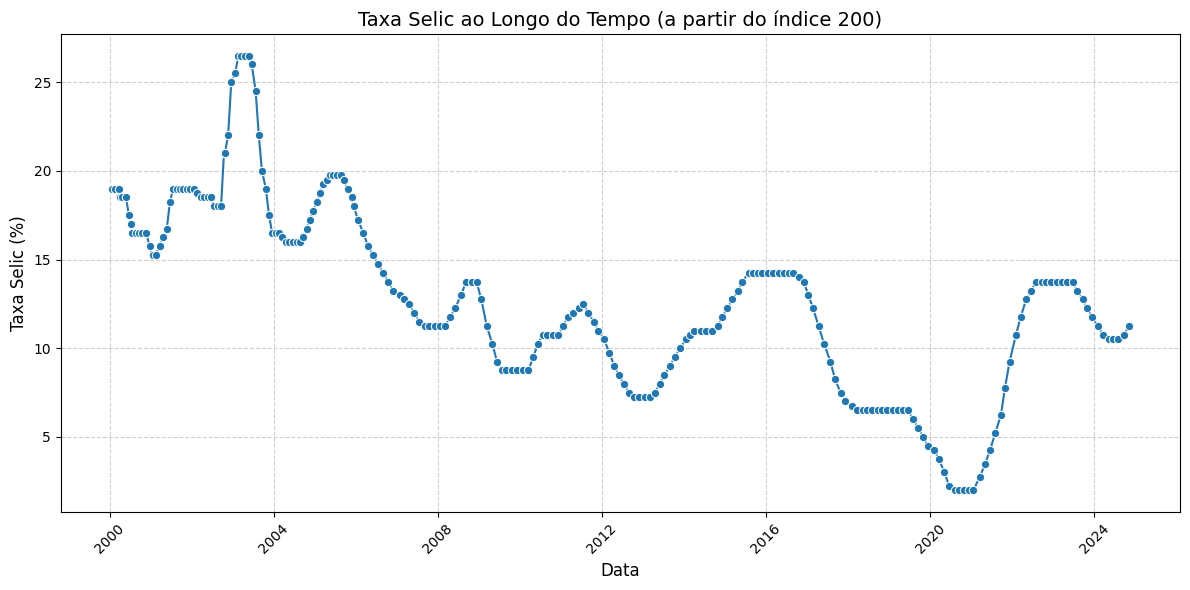

In [127]:
dados_plotagem = dados_selic.copy()
dados_plotagem['Data'] = pd.to_datetime(dados_plotagem['Data'], format='%d/%m/%Y')

# Criando o gráfico com Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=dados_plotagem, x='Data', y='Taxa_Selic', marker="o")

# Personalizando o gráfico
plt.title("Taxa Selic ao Longo do Tempo (a partir do índice 200)", fontsize=14)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Taxa Selic (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

In [44]:
dados.columns

Index(['Data', 'Taxa_Selic'], dtype='object')

In [45]:
dados.isna().sum()

Data          0
Taxa_Selic    0
dtype: int64

 - Alterando o tipo da taxa selic

In [17]:
dados_selic["Taxa_Selic"] = dados_selic["Taxa_Selic"].replace(",", ".", regex=True)

In [18]:
# Alterando os tipos das variaveis
dados_selic['Taxa_Selic'] = dados_selic['Taxa_Selic'].astype(float)

In [46]:
dados_selic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 48 to 273
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Data        226 non-null    object 
 1   Taxa_Selic  226 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.7+ KB


In [47]:
# Fazer plotagens da inflação aqui
dados_selic_plot = dados_selic.copy()

 - Iniciando Pré Processamento dos dados

In [48]:
# Transformando a taxa selic em Matriz

selic = dados_selic['Taxa_Selic'].values.reshape(-1, 1)

In [49]:
# Função para criar o dataset para o modelo LSTM com look_back
# O parâmetro look back define o numero de passos no tempo que o modelo usará para fazer cada previsõa
# a ideia de "veja os ultimos 3 dados e preveja o 4"

def func_cria_dataset(data, look_back = 1):
   
   # Inicializa duas listas vazias, X e Y, que conterão as sequências de entrada e saída
   X, Y = [], []
   # Itera pelo conjunto de dados menos o valor de look_back, Isso é feiro para evitar índices fora dos limites do array
   for i in range(len(data) - look_back):      
      # Coleta uma sequência de dados de tamanho look_back começando no índice i
      a = data[i:(i + look_back), 0]
      # Adiciona a sequência à lista X
      X.append(a)
      # Adiciona o valor imediatamente após a sequência de look_back à lista Y. Esse valor será o target.
      Y.append(data[i + look_back, 0])

   # Converte X e Y para arrays numpy para compatibilidade com a maioria das bibliotecas de machine learninog
   return np.array(X), np.array(Y)

In [52]:
# Dividimos os dados em treinamento e teste (respeitando a ordem cronológica dos dados)

indice = int(len(selic) * 0.85)
dados_treino, dados_teste = selic[0:indice, :], selic[indice:len(selic), :] 

In [54]:
dados_treino[:10]

array([[19. ],
       [19. ],
       [19. ],
       [18.5],
       [18.5],
       [18.5],
       [17.5],
       [17. ],
       [16.5],
       [16.5]])

In [55]:
len(dados_treino), len(dados_teste)

(192, 34)

In [56]:
# Normaliza os dados (Requerimento para redes neurais)

scaler = MinMaxScaler(feature_range = (0, 1))

In [59]:
# Treina e aplica o sclaer emt reino e somente aplica em teste

dados_treino_norm = scaler.fit_transform(dados_treino)
dados_teste_norm = scaler.transform(dados_teste)

In [62]:
dados_teste_norm[:20]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.03061224],
       [0.06122449],
       [0.09183673],
       [0.13265306],
       [0.17346939],
       [0.23469388],
       [0.29591837],
       [0.35714286],
       [0.39795918],
       [0.43877551],
       [0.45918367],
       [0.47959184],
       [0.47959184],
       [0.47959184],
       [0.47959184],
       [0.47959184]])

In [89]:
#  Criamos os datasets para o modelo LSTM

look_back = 3
X_treino, y_treino = func_cria_dataset(dados_treino_norm, look_back)
X_teste, y_teste = func_cria_dataset(dados_teste_norm, look_back)

In [90]:
X_treino[:5]

array([[0.69387755, 0.69387755, 0.69387755],
       [0.69387755, 0.69387755, 0.67346939],
       [0.69387755, 0.67346939, 0.67346939],
       [0.67346939, 0.67346939, 0.67346939],
       [0.67346939, 0.67346939, 0.63265306]])

In [91]:
y_treino[:9]

array([0.67346939, 0.67346939, 0.67346939, 0.63265306, 0.6122449 ,
       0.59183673, 0.59183673, 0.59183673, 0.59183673])

In [92]:
#  Reshape dos dados para [samples, time steps, features] - Requerimento para o modelo LSTM

X_treino = np.reshape(X_treino, (X_treino.shape[0], X_treino.shape[1], 1))
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

In [93]:
X_treino[:2]

array([[[0.69387755],
        [0.69387755],
        [0.69387755]],

       [[0.69387755],
        [0.69387755],
        [0.67346939]]])

## <font color = "red"> Construção do Modelo LSTM

In [115]:
# 50 neurônios artificais

modelo = tf.keras.models.Sequential([tf.keras.layers.LSTM(60, input_shape = (look_back, 1)),
                                     tf.keras.layers.Dense(1)])

In [116]:
# Compila o modelo
# Nesta etapa, aplica o algorítmo de otimização que aplica o back propagation, no caso foi o "adam"
# função de erro 
modelo.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [117]:
# Treinamento do modelo
# Batch_size = alimenta 1 registro por vez
# verbose mostra na tela o treinmaneot em andamento

modelo.fit(X_treino, y_treino, epochs = 50, batch_size = 1, verbose = 1)

Epoch 1/50
189/189 [==============================] - 3s 2ms/step - loss: 0.0256
Epoch 2/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 3/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 4/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 5/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 6/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 7/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 8/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 9/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 10/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 11/50
189/189 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 12/50
189/189 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 13/50
189/189 [====

In [118]:
# Fazendo previsões com o modelo

previsao_treino = modelo.predict(X_treino)
previsao_teste = modelo.predict(X_teste)

1/1 [==============================] - 0s 20ms/step


## CALCULANDO ERRO

In [119]:
# Transformar de volta para a escala orignial e calcular o erro do modelo

previsao_treino = scaler.inverse_transform(previsao_treino)
y_treino_rescaled = scaler.inverse_transform([y_treino])
previsao_teste = scaler.inverse_transform(previsao_teste)
y_teste_rescaled = scaler.inverse_transform([y_teste])

In [120]:
y_teste_rescaled

array([[ 2.  ,  2.75,  3.5 ,  4.25,  5.25,  6.25,  7.75,  9.25, 10.75,
        11.75, 12.75, 13.25, 13.75, 13.75, 13.75, 13.75, 13.75, 13.75,
        13.75, 13.75, 13.25, 12.75, 12.25, 11.75, 11.25, 10.75, 10.5 ,
        10.5 , 10.5 , 10.75, 11.25]])

In [121]:
# Calcula o RMSE

train_score = np.sqrt(mean_squared_error(y_treino_rescaled[0],
                                         previsao_treino[:,0]))
print(f"\nRMSE em treino: {train_score:.2f}\n")

teste_score = np.sqrt(mean_squared_error(y_teste_rescaled[0],
                                         previsao_teste[:,0]))
print(f"\nRMSE em teste: {teste_score:.2f}\n")


RMSE em treino: 0.77


RMSE em teste: 0.67



In [122]:
# Ajustar os índices para dados originais e previsões a fim de entregar o resultado em formato de plot

# Cria um índice para os dados de treino originais, começando em 'look_back' e terminando em 'look_back + len(y_treino_rescaled[0])'.
# Este índice será utilizado para associar cada ponto de dado de treino ao seu ano correspondente no DataFrame 'df_dsa'.
original_train_data_index = dados_selic['Data'][look_back:look_back + len(y_treino_rescaled[0])]

# Cria um índice para os dados de teste originais.
# Começa a partir do final dos dados de treino padronizados e vai até o final dos dados de teste padronizados.
# O '2 * look_back' é utilizado para ajustar o índice corretamente.
original_test_data_index = dados_selic['Data'][len(y_treino_rescaled[0]) + 2 * look_back:len(y_treino_rescaled[0]) + 2 * look_back + len(y_teste_rescaled[0])]

# Cria um índice para os valores previstos em treino, começando em 'look_back' e terminando em 'look_back + len(previsao_treino)'.
# Este índice será utilizado para associar cada ponto previsto no conjunto de treino ao seu Data correspondente no DataFrame 'dados_selic'.
predicted_train_data_index = dados_selic['Data'][look_back:look_back + len(previsao_treino)]

# Cria um índice para os valores previstos em teste.
predicted_test_data_index = dados_selic['Data'][len(y_treino_rescaled[0]) + 2 * look_back:len(y_treino_rescaled[0]) + 2 * look_back+len(previsao_teste)]



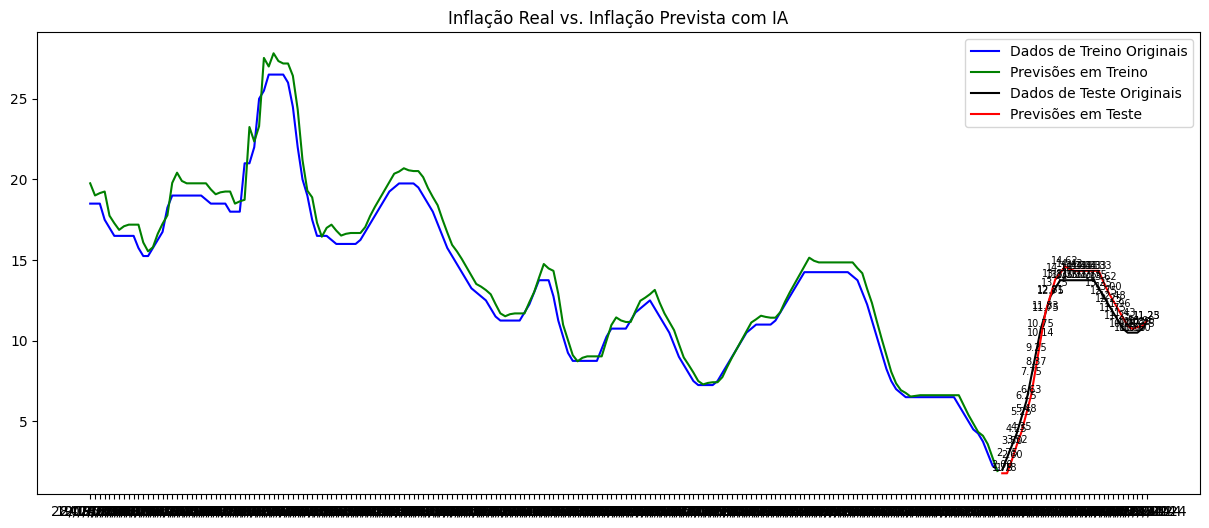

In [123]:
# Plotar os resultados
plt.figure(figsize = (15,6))

plt.plot(original_train_data_index, y_treino_rescaled[0], label = "Dados de Treino Originais", color = "blue")

plt.plot(predicted_train_data_index, previsao_treino[:, 0], label = "Previsões em Treino", color = "green")

plt.plot(original_test_data_index, y_teste_rescaled[0], label = "Dados de Teste Originais", color = "black")

for i, value in enumerate(y_teste_rescaled[0]):
    plt.annotate(f"{value:.2f}", (original_test_data_index.iloc[i], value), fontsize = 7, ha = 'center', va = 'bottom')

plt.plot(predicted_test_data_index, previsao_teste[:, 0], label = "Previsões em Teste", color = "red")

for i, value in enumerate(previsao_teste[:, 0]):
    plt.annotate(f"{value:.2f}", (predicted_test_data_index.iloc[i], value), fontsize = 7, ha = 'center', va = 'bottom')

plt.title("Inflação Real vs. Inflação Prevista com IA")
plt.legend()
plt.show()

In [124]:
last_data = dados_teste_norm[-look_back:]
last_data = np.reshape(last_data, (1, look_back, 1))

# Lista
lista_previsoes = []

# Loop de Previsão para prever 2 anos (2024 e 2025)
for _ in range(2):  

    # Previsão com o modelo (usamos os dados normalizados)
    prediction = modelo.predict(last_data)

    # Adiciona a previsão à lista de previsões
    lista_previsoes.append(prediction[0, 0])

    # Atualiza os dados para incluir a nova previsão e remover o valor mais antigo
    last_data = np.roll(last_data, shift = -1)
    last_data[0, look_back - 1, 0] = prediction

# Transformar de volta para a escala original
lista_previsoes_rescaled = scaler.inverse_transform(np.array(lista_previsoes).reshape(-1, 1))

print(f"\nPrevisão da Inflação Para 2024: {lista_previsoes_rescaled[0, 0]:.2f}")
print(f"Previsão da Inflação Para 2025: {lista_previsoes_rescaled[1, 0]:.2f}")

print("\nLab Concluído. Obrigado, DSA!")


1/1 [==============================] - 0s 28ms/step

Previsão da Inflação Para 2024: 11.89
Previsão da Inflação Para 2025: 12.67

Lab Concluído. Obrigado, DSA!


In [125]:
last_data

array([[[0.37755102],
        [0.40370393],
        [0.43553445]]])